### Numerical Model for Ocean Flow
Sierra Stevenson under mentorship of Dr. Marcelo Chamecki

We are solving the system of equations

$$
\begin{cases}

\frac{\partial{\bar{u}}}{\partial{t}} &= f(\bar{v} - v_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{u}}}{\partial{z}} + k \frac{\partial{^2\bar{u}}}{\partial{z^2}} 
\\
\frac{\partial{\bar{v}}}{\partial{t}} &= f(\bar{u} - u_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{v}}}{\partial{z}} + k \frac{\partial{^2\bar{v}}}{\partial{z^2}}

\end{cases}
$$

with boundary conditions

*surface ($z=0$):*  $k \frac{\partial{\bar{u}}}{\partial{z}} = \frac{T_x}{\rho}$,  $k \frac{\partial{\bar{v}}}{\partial{z}} = \frac{T_y}{\rho}$

*bottom ($z=-\infty$):* $\bar{u} = u_g, \bar{v} = v_g$


___
<center>
Centered discretization <p>

$$
\begin{align}

\frac{\partial u_i}{\partial t} &= f (v_i - v_g) - \frac{1}{\Delta z} \biggr[-K_i \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i-\frac{1}{2}} + K_{i+1} \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i+\frac{1}{2}}\biggr]\\
&= f (v_i - v_g) + \frac{1}{\Delta z} \biggr[K_i \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i-\frac{1}{2}} - K_{i+1} \Bigl(\frac{\partial u}{\partial z}\Bigr)_{i+\frac{1}{2}}\biggr]\\
&= f (v_i - v_g) + \frac{1}{\Delta z} \biggr[\Bigl(\frac{K_i}{\Delta z}\Bigr)(u_{i-1}-u_i)-\Bigl(\frac{K_{i+1}}{\Delta z}\Bigr)(u_{i}-u_{i+1})\biggr]\\
&= f (v_i - v_g) + \frac{1}{\Delta z^2} \biggr[K_i(u_{i-1}-u_i)-K_{i+1}(u_{i}-u_{i+1})\biggr]


\end{align}
\\
\text{With nonlocal term } \gamma \text{=} \frac{C_s \left( -\tau_x / \rho_0 \right)^{-1/2}}{u_s h}\\

\begin{align}
&= f (v_i - v_g) + \frac{1}{\Delta z^2} \biggr[K_i\bigl((u_{i-1}-u_i)-\gamma\bigr)-K_{i+1}\bigl((u_{i}-u_{i+1})-\gamma\bigr)\biggr]\\



\end{align}
$$

Boundary conditions <p>
$$
\begin{align}

\tau &= \rho_0 K \Bigl(\frac{du}{dz}\Bigr) \\
\frac{\tau}{\rho_0} &= K \Bigl(\frac{du}{dz}\Bigr) \\
\therefore 
\frac{\partial u_0}{\partial t} &= f (v_0 - v_g) + \frac{1}{\Delta z}\biggr[\frac{\tau}{\rho_0} -\Bigl(\frac{K_1}{\Delta z}\Bigr)(u_{0}-u_{1})\biggr]
\\
\\
u_{bottom} &= u_g

\end{align}

$$
___


___
<center>
Looping with <br>
Runge-Kutta 4 <p>

$\tilde{u}_1 = u^n + \frac{\Delta t}{2}F(u^n) \newline$ <p>
$\tilde{u}_2 = u^n + \frac{\Delta t}{2}F(\tilde{u}_1^n) \newline$ <p>
$\tilde{u}_3 = u^n + \Delta t F(\tilde{u}_2^n) \newline$ <p>
$u^{n+1} = u^n + \frac{\Delta t}{6}[F(u^n) + 2F(\tilde{u_1}) + 2F(\tilde{u_2}) + F(\tilde{u_3})] \newline$ <p>

___


In [3]:
# TODO
# calculate model h
# plot h vs h (LES vs model)
# get G_l, g_s from paper
# plot u, v profiles
# change path name for dataset (import os using getcwd())

# Code

Import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erf
%matplotlib inline
 
# Font style for plotting
# plt.rcParams["font.family"] = "Georgia"
# plt.rcParams["font.size"] = 10

Grid

In [5]:
# Time
T = 200000                          # total seconds
dt = 1                              # time step
Nt = int(T/dt)                      # number of time steps

# Space
Z = 100                             # total meters deep
dz = 1                              # step in z
Nz = int(Z/dz)                      # number of grid nodes
z_K = np.arange(0, -Z, -dz)         # z array from [0, -100]
z = (z_K - (dz/2))                  # z array for K, staggered as i + 1/2

# Print info
print(f"z_K:\t{z_K[0]},\t{z_K[1]},\t...,\t{z_K[-1]}")   # start 0
print(f"z:\t{z[0]},\t{z[1]},\t...,\t{z[-1]}")           # start at -0.5 below (dz*0.5 below surface)
print(f"\nhours of simulation: {round(T/60/60,1)}")

z_K:	0,	-1,	...,	-99
z:	-0.5,	-1.5,	...,	-99.5

hours of simulation: 55.6


Constants

In [6]:
f = 7 * 10 ** (-5)                  # coriolis parameter
tau_x_over_rho = 10 ** (-4)         # wind stress (tau_x / rho)
tau_y_over_rho = 0                  # wind stress (tau_y / rho)
ug, vg = 0, 0                       # geostrophic velocity
threshold_epsilon = 0.10            # nondimensional extent of surface layer

LES data

In [7]:
# Create dataframe of LES runs data
LES_runs = pd.read_csv("C:/Users/Sierra/Desktop/Chamecki Lab/LES_runs/all_LES_runs(1).txt", sep=None, engine="python").rename({"A" : "Lambda"}, axis = 1)
LES_runs['h'] = [-66.8,-67.5,-60,-60,-66.8,-61.9, -63.8, -64.5, -64.9, -68.2, -62.2, -64.9, -58.5]  # Add h (boundary layer depth) values from paper
LES_runs['La_SL'] = [0.28,0.52,1.70,0,0.69,0.51,0,1.74,0.75,3.47,1.51,0.51,0]
run_names = np.array(LES_runs['Name'])
file_names = ["wu00L02","wu00L03","wu00L10","wu00Lin","wu00L04","wu01L03","wu01Lin","wu01L10","wu02L04","wu03L20","wu10L09","wu20L03","wu0inLna"]
path = "C:/Users/Sierra/Desktop/Chamecki Lab/LES_runs/"
files = LES_runs["File"].values

df = {}
for run_name, file, file_name in zip(run_names, files, file_names):
        df[run_name] = pd.read_csv(path + file)

In [8]:
df["Joint PDF Peak"]

,z,u,v,θ,u2,v2,ε,uv,u2_sgs,v2_sgs,uv_sgs,u3_res,v3_res,p,σ
0,-0.1875,0.021170,-0.017529,283.099472,0.000708,0.000667,-1.509988e-06,5.228808e-08,1.638878e-06,4.957591e-06,5.228808e-08,2.521864e-05,-2.417134e-05,-0.000687,0.002890
1,-0.5625,0.007635,-0.017304,283.101709,0.000278,0.000603,-1.388026e-06,-1.426544e-06,5.345648e-07,1.398985e-06,-9.269505e-08,5.676676e-06,-2.088718e-05,-0.001171,0.008671
2,-0.9375,0.005204,-0.017113,283.102531,0.000185,0.000556,-6.162409e-07,-2.415328e-06,1.536014e-07,4.585550e-07,-7.792460e-08,2.859637e-06,-1.854093e-05,-0.001263,0.014451
3,-1.3125,0.002593,-0.016895,283.103094,0.000144,0.000521,-4.258612e-07,-3.284447e-06,2.029005e-08,3.037201e-08,-1.035214e-07,1.401168e-06,-1.679222e-05,-0.001348,0.020231
4,-1.6875,0.001426,-0.016698,283.103472,0.000122,0.000494,-3.318198e-07,-4.036435e-06,-7.049971e-08,-9.085653e-08,-1.215431e-07,8.189056e-07,-1.545625e-05,-0.001386,0.026012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-110.8125,-0.000088,0.000049,282.012123,0.000001,0.000002,-1.254616e-10,-3.437352e-07,-2.039426e-09,-1.934992e-09,3.389868e-11,-3.249429e-10,4.634250e-10,-0.001399,1.708092
296,-111.1875,-0.000088,0.000053,282.004645,0.000001,0.000002,-1.250375e-10,-3.426329e-07,-2.029680e-09,-1.929786e-09,4.024648e-11,-3.434116e-10,3.831526e-10,-0.001399,1.713873
297,-111.5625,-0.000089,0.000058,281.997165,0.000001,0.000002,-1.242968e-10,-3.413767e-07,-2.030371e-09,-1.950839e-09,2.585511e-11,-3.651109e-10,3.134699e-10,-0.001399,1.719653
298,-111.9375,-0.000089,0.000062,281.989676,0.000001,0.000003,-1.238779e-10,-3.400674e-07,-2.023324e-09,-1.938429e-09,2.269592e-11,-3.861576e-10,2.634083e-10,-0.001399,1.725434


Define K using LES for comparison

In [9]:
def H(x): # Heaviside function used to get nonlocal flux
    if isinstance(x, (float, int)):
        return 1 if x >= 0 else 0
    else:
        return [H(xi) for xi in x]

def getK(run_name, ons):
    # Scalars from LES runs
    u_star  = LES_runs.loc[LES_runs["Name"]==run_name]["u_star"].squeeze()
    # h       = LES_runs.loc[LES_runs["Name"]==run_name]["h"].squeeze()       # Added manually from table in paper
    B_s     = LES_runs.loc[LES_runs["Name"]==run_name]["B_s"].squeeze()
    La_SL   = LES_runs.loc[LES_runs["Name"]==run_name]["La_SL"].squeeze()   # Added manually from table in paper
    lamb    = LES_runs.loc[LES_runs["Name"]==run_name]["Lambda"].squeeze()
    La_t    = LES_runs.loc[LES_runs["Name"]==run_name]["La_t"].squeeze()   # Added manually from table in paper
    
    # Terms defined in paper
    kappa = 0.4
    u_s = kappa * u_star
    h = -0.7 * u_star / f # NEW
    print(h)
    sigma = z_K/h
    Gn = sigma * (1 - sigma) ** 2
    c4, c5, c6 = 45, -33, 9
    Gl = sigma * (1 - sigma)**2 * (1 + c4 * sigma + c5 * (sigma + sigma **2) + c6 * (3*sigma + 2*sigma**2 + sigma**3))
    Gk = Gn if (lamb < 10 ** -3 and La_t > 10) else Gl
    Gk = Gn
    tau_x_over_rho = u_star ** 2
    
    # Create K
    K = u_s * np.abs(h) * Gk

    # Enhancement parameters
    phi, epsilon, gamma = np.ones_like(K), np.ones_like(K), [np.zeros_like(K[1:-1]), np.zeros_like(K[1:-1])]

    # CONVECTION %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    if "phi_on" in ons:  # Convection term
        zeta = np.zeros_like(sigma)

        # Create zeta array, or set to one if no convection
        if B_s: # Surface buoyancy
            L_o = (u_star ** 3)/(kappa*B_s)
            if L_o:
                zeta = z_K/ L_o
            else:
                print("phi on, B_s, but no L_o")
        else:
            print("phi on but no B_s")
        
        phi = np.ones_like(sigma) # Create array of ones
    
        # Eq. B1 from Large, et al
        if any(zeta):
            for i in range(len(zeta)):
                if zeta[i] >= 0:                            # Eq. B1a
                    phi[i] = 1 + 5*zeta[i]
                elif zeta[i] >= -0.2 and zeta[i] < 0:       # Eq. B1b
                    phi[i] = (1-16*zeta[i])**(-1/4)
                elif zeta[i] < -0.2:                        # Eq. B1c
                    phi[i] = (1.26-8.38*zeta[i])**(-1/3)
        
        # Cap phi at its value at sigma = 0.1
        for i in range(len(sigma)):
            if sigma[i] >= 0.1:
                phi[i:] = phi[i]
                break
        K = K / phi
    
    # MOMENTUM %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    if "epsilon_on" in ons:  # Wave momentum term
        # Reichl et al (2016) formulation
        if La_SL: # La_SL is shown in the paper for only 10 of the 13 LES runs; don't calculate epsilon for omitted runs (yet)
            epsilon_prime = min(2.25, 1 + 1/La_SL)
            epsilon = 1 + (epsilon_prime - 1) * (Gn / max(Gn))
        else:
            print("eps on, but no La_SL found.")
        K = K * epsilon

    # NONLOCAL FLUX %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    if "gamma_on" in ons:    # Nonlocal flux term
        c_s = 98.96 # nondimensional const.; see Large et al (cited as such in Chor paper)
        C_s = 5 * kappa * (0.1 * c_s * kappa) ** 1/3
        if u_s:
            gamma_u = C_s * (-tau_x_over_rho) ** 1/2 / (u_s * abs(h))
            gamma_v = C_s * (-tau_y_over_rho) ** 1/2 / (u_s * abs(h))
            gamma = [gamma_u, gamma_v]

        # New Gs %%%%
        # gs = 2 * (sigma - 0.2) * (1 - sigma) ** 2 * H(sigma - 0.2)

        # lamb_c = kappa
        # L1 = 0.95
        # C1 = 1.95
        # C2 = 1.82
        # La_c = 10
        # Langmuir = L1 * (1 - H(La_t - La_c))
        # Convection = C1 * H(lamb) * ((1+erf(C2 * (lamb - lamb_c))))/2
        # Gs = (Langmuir + Convection) * gs
        # gamma = [Gs[1:-1] * (-tau_x_over_rho), Gs[1:-1] * (-tau_y_over_rho)]

    # Modify K
    for i in range(len(K)):
        if sigma[i] > 1:
            K[i] = 0

    return tau_x_over_rho, K, sigma, phi, gamma

Main loop

In [10]:
# Functions to use in the loop

def F(u_val, v_val, K, tau_x_over_rho, tau_y_over_rho, gamma):
    F_u, F_v = np.zeros(Nz), np.zeros(Nz)

    # Interior nodes
    F_u[1:-1] =  (f * (v_val[1:-1] - vg) + (1/dz**2) * (K[1:-1])*((u_val[0:-2] - u_val[1:-1]) - gamma[0])) - (K[2:]*((u_val[1:-1] - u_val[2:]) - gamma[0]))
    F_v[1:-1] = (-f * (u_val[1:-1] - ug) + (1/dz**2) * (K[1:-1])*((v_val[0:-2] - v_val[1:-1]) - gamma[1])) - (K[2:]*((v_val[1:-1] - v_val[2:]) - gamma[1]))

    return F_u[1:-1], F_v[1:-1]

def BC(u_val, v_val, K, tau_x_over_rho, tau_y_over_rho):

    # Boundaries
    F_u_top =  (f * (v_val[0] - vg) + (1/dz) * (tau_x_over_rho - (K[1]/dz) * (u_val[0] - u_val[1])))
    F_v_top = (-f * (u_val[0] - ug) + (1/dz) * (tau_y_over_rho - (K[1]/dz) * (v_val[0] - v_val[1])))

    return F_u_top, F_v_top


In [11]:
saverate = 5
def runLoop(run_name, testing=True, get_saved=False):
    print(run_name + " ———————————————————————")
    LES_u, LES_v = df[run_name]["u"][::int(3/dz)], df[run_name]["v"][::int(3/dz)]
    all_uverr, all_saved = [], []

    # Test enhancement factors
    if testing:
        tests = [{"epsilon_on", "phi_on", "gamma_on"},   # eps phi gamma
                 {"epsilon_on", "phi_on"},               # eps phi
                 {"epsilon_on"},                         # eps
                 {"phi_on"},                             # phi
                 {}                                      # none
                ]
    else:
        tests = [{"epsilon_on", "phi_on", "gamma_on"}]

    for test in tests:
        print(test)

        tau_x_over_rho, K, sigma, phi, gamma = getK(run_name, test)

        # fig, [ax1, ax2, ax3] = plt.subplots(ncols=3)
        # fig.suptitle(test)
        # ax1.plot(K, -sigma)
        # ax1.set_xlabel("K")
        # ax1.set_ylabel("-sigma")
        # ax1.legend()

        # Initialize arrays for next time step
        u,       v       = np.zeros(Nz), np.zeros(Nz)
        u_1,     v_1     = np.zeros(Nz), np.zeros(Nz)
        u_2,     v_2     = np.zeros(Nz), np.zeros(Nz)
        u_3,     v_3     = np.zeros(Nz), np.zeros(Nz)
        u_fut,   v_fut   = np.zeros(Nz), np.zeros(Nz)
        u_saved, v_saved = np.zeros((Nz, int(Nt/saverate))), np.zeros((Nz, int(Nt/saverate)))
        tau_y_over_rho   = 0

        # RK4
        for n in np.arange(0, T, dt):  # Loop thru time, Nt times
            
            # Intermediate 1
            F_u,  F_v  = F(u, v, K, tau_x_over_rho, tau_y_over_rho, gamma)
            BC_u, BC_v = BC(u, v, K, tau_x_over_rho, tau_y_over_rho)
            u_1[1:-1] = u[1:-1] + (dt/2) * F_u            # [0] gives the u array
            v_1[1:-1] = v[1:-1] + (dt/2) * F_v            # [1] gives the v array 
            u_1[0]    = u[0]    + (dt/2) * BC_u
            v_1[0]    = v[0]    + (dt/2) * BC_v
            u_1[-1], v_1[-1] = ug, vg
            
            # Intermediate 2
            F_u_1,  F_v_1  = F(u_1, v_1, K, tau_x_over_rho, tau_y_over_rho, gamma)
            BC_u_1, BC_v_1 = BC(u_1, v_1, K, tau_x_over_rho, tau_y_over_rho)
            u_2[1:-1] = u[1:-1] + (dt/2) * F_u_1
            v_2[1:-1] = v[1:-1] + (dt/2) * F_v_1
            u_2[0]    = u[0]    + (dt/2) * BC_u_1
            v_2[0]    = v[0]    + (dt/2) * BC_v_1
            u_2[-1], v_2[-1] = ug, vg

            # Intermediate 3
            F_u_2,  F_v_2  = F(u_2, v_2, K, tau_x_over_rho, tau_y_over_rho, gamma)
            BC_u_2, BC_v_2 = BC(u_2, v_2, K, tau_x_over_rho, tau_y_over_rho)
            u_3[1:-1] = u[1:-1] + (dt) * F_u_2
            v_3[1:-1] = v[1:-1] + (dt) * F_v_2
            u_3[0]    = u[0]    + (dt) * BC_u_2
            v_3[0]    = v[0]    + (dt) * BC_v_2
            u_3[-1], v_3[-1] = ug, vg

            # Next velocity vector in time
            F_u_3,  F_v_3  = F(u_3, v_3, K, tau_x_over_rho, tau_y_over_rho, gamma)
            BC_u_3, BC_v_3 = BC(u_3, v_3, K, tau_x_over_rho, tau_y_over_rho)
            u_fut[1:-1] = u[1:-1] + (dt/6) * (F_u  + 2*F_u_1  + 2*F_u_2  + F_u_3)
            v_fut[1:-1] = v[1:-1] + (dt/6) * (F_v  + 2*F_v_1  + 2*F_v_2  + F_v_3) 
            u_fut[0]    = u[0]    + (dt/6) * (BC_u + 2*BC_u_1 + 2*BC_u_2 + BC_u_3)
            v_fut[0]    = v[0]    + (dt/6) * (BC_v + 2*BC_v_1 + 2*BC_v_2 + BC_v_3) 
            u_fut[-1], v_fut[-1] = ug, vg

            # Update u and v to restart loop with new starting values
            u = np.copy(u_fut)
            v = np.copy(v_fut)

            # Save history
            if (n/dt)%saverate == 0:
                u_saved[:,int((n/dt)/saverate)] = np.copy(u)
                v_saved[:,int((n/dt)/saverate)] = np.copy(v)

        # Get average value of u and v oscillations
        u_avg = np.mean(u_saved[-int(2*np.pi/f):], axis=1)
        v_avg = np.mean(v_saved[-int(2*np.pi/f):], axis=1)
        print(f"Finished calculating values.")

        # ax2.plot(u_avg, z_K)
        # ax2.set_xlabel("u")
        # ax2.set_ylabel("z")

        # ax3.plot(u_avg, v_avg)
        # ax3.set_xlabel("u")
        # ax3.set_ylabel("v")

        # Get error
        error_u, error_v = [np.sqrt(sum((u_avg - LES_u) ** 2))], [np.sqrt(sum((v_avg - LES_v) ** 2))]

        all_uverr.append([u_avg, v_avg, error_u, error_v])
        all_saved.append([u_saved, v_saved])

    return [LES_u, LES_v], all_uverr # note all_saved is NOT returned

Plots

Dictionary of runs

In [12]:
# runtime: 5 min/run * 13 runs = 1 hr
# Full runs
runs = { # run name 
    # 'Neutral Swell':                [*runLoop('Neutral Swell',               testing=True)],              
    # 'Neutral Wind-Wave Eq.':        [*runLoop('Neutral Wind-Wave Eq.',       testing=True)],      
    # 'Neutral Weak Waves':           [*runLoop('Neutral Weak Waves',          testing=True)],         
    # 'Pure Wind Stress':             [*runLoop('Pure Wind Stress',            testing=True)],           
    # 'Weak Conv + Waves':            [*runLoop('Weak Conv + Waves',           testing=True)],          
    # 'Weak Conv + Wind-Wave Eq.':    [*runLoop('Weak Conv + Wind-Wave Eq.',   testing=True)],  
    # 'Weak Conv + Waveless':         [*runLoop('Weak Conv + Waveless',        testing=True)],       
    # 'Weak Conv+ Weak Waves':        [*runLoop('Weak Conv+ Weak Waves',       testing=True)],          
    'Joint PDF Peak':               [*runLoop('Joint PDF Peak',              testing=True)],             
    # 'Weak Conv + very Weak Waves':  [*runLoop('Weak Conv + very Weak Waves', testing=True)], 
    # 'Strong Conv + weak Waves':     [*runLoop('Strong Conv + weak Waves',    testing=True)],   
    # 'Strong Conv + Wind-Wave Eq':   [*runLoop('Strong Conv + Wind-Wave Eq',  testing=True)],  
    # 'Pure Convection':              [*runLoop('Pure Convection',             testing=True)]
}


Joint PDF Peak ———————————————————————
{'epsilon_on', 'gamma_on', 'phi_on'}
-69.99999999999999
Finished calculating values.
{'epsilon_on', 'phi_on'}
-69.99999999999999
Finished calculating values.
{'epsilon_on'}
-69.99999999999999
Finished calculating values.
{'phi_on'}
-69.99999999999999
Finished calculating values.
{}
-69.99999999999999
Finished calculating values.


$u$ vs. $v$ hodograph

In [13]:
#        0     1       2        3
# 0 les[u,     v]
# 1 model
#   0 epg[u_avg, v_avg, error_u, error_v]
#   1 ep[u_avg,  v_avg, error_u, error_v]
#   2 e[u_avg,   v_avg, error_u, error_v]
#   3 p[u_avg,   v_avg, error_u, error_v]
#   4 n[u_avg,   v_avg, error_u, error_v] 

def PlotRun(run_list, testing=True):
    colors = ['red','orange','goldenrod','blue','darkgreen']

    for run in runs:

        LES_u, LES_v                       = runs[run][0][0],     runs[run][0][1]    # LES
        epg_u, epg_v, epg_err_u, epg_err_v = runs[run][1][0][0],  runs[run][1][0][1], runs[run][1][0][2],  runs[run][1][0][3],     # eps phi gam
        
        plt.figure(figsize=(5,5))
        plt.plot(LES_u, LES_v,  color="black", alpha=1.00, ls=":", label=f"LES")
        plt.plot(epg_u, epg_v,  color="red",   alpha=0.75, ls="-", label=f"$\epsilon, \phi, \gamma$  Error = {float(str(epg_err_u)[1:7]), float(str(epg_err_v)[1:7])}")

        if testing:
            ep_u, ep_v, ep_err_u, ep_err_v = runs[run][1][1][0],  runs[run][1][1][1], runs[run][1][1][2],  runs[run][1][1][3],     # eps phi
            e_u, e_v, e_err_u, e_err_v     = runs[run][1][2][0],  runs[run][1][2][1], runs[run][1][2][2],  runs[run][1][2][3],     # eps 
            p_u, p_v, p_err_u, p_err_v     = runs[run][1][3][0],  runs[run][1][3][1], runs[run][1][3][2],  runs[run][1][3][3],     # phi
            n_u, n_v, n_err_u, n_err_v     = runs[run][1][4][0],  runs[run][1][4][1], runs[run][1][4][2],  runs[run][1][4][3],     # none

            plt.plot(ep_u, ep_v, color="orange",        alpha=0.60, ls="-", label=f"$\epsilon, \phi$     Error = {float(str(ep_err_u)[1:6]), float(str(ep_err_v)[1:6])}")           
            plt.plot(e_u,   e_v, color="darkseagreen",  alpha=0.60, ls="-", label=f"$\epsilon$          Error = {  float(str(e_err_u)[1:6]),  float(str(e_err_v)[1:6])}")                       
            plt.plot(p_u,   p_v, color="slateblue",     alpha=0.45, ls="-", label=f"$\phi$         Error = {      float(str(p_err_u)[1:6]),  float(str(p_err_v)[1:6])}")                           
            plt.plot(n_u,   n_v, color="silver",        alpha=0.45, ls="-", label=f"none    Error = {             float(str(n_err_u)[1:6]),  float(str(n_err_v)[1:6])}")                               

        plt.xlabel('u')
        plt.ylabel('v')
        plt.legend()
        plt.title(run)
        plt.show()

$u$ and $v$ depth profiles

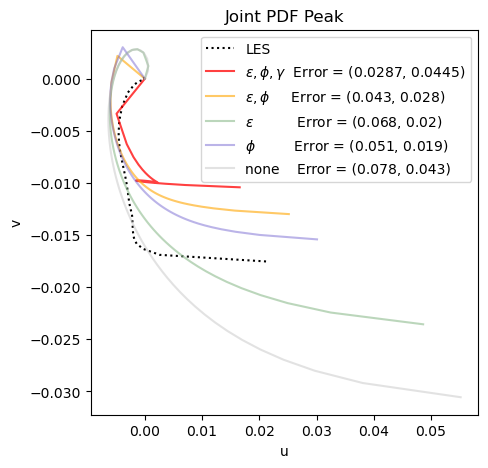

In [14]:
PlotRun(runs)

In [15]:
# # [{"epsilon_on", "phi_on", "gamma_on"},   # eps phi gamma
# #                  {"epsilon_on", "phi_on"},               # eps phi
# #                  {"epsilon_on"},                         # eps
# #                  {"phi_on"},                             # phi
# #                  {}                                      # none
# #                 ]

# u_avg, v_avg, _, _, = uv[3]

# # Model plot
# a = 2
# b = -1

# u_compare, v_compare = les

# # u_avg, v_avg, u_compare, v_compare = WCWaveless_u, WCWaveless_v, LES_WCWaveless_u[::3], LES_WCWaveless_v[::3]

# plt.plot(u_avg[a:b], z[a:b], label="u(z), Model", color="green")
# plt.plot(v_avg[a:b], z[a:b], label="v(z), Model", color="darkblue")

# # Analytical plot
# plt.plot(u_compare, z, label="u(z), Solution", color="darkgreen", alpha=0.5, linestyle="--")
# plt.plot(v_compare, z, label="v(z), Solution", color="indigo", alpha=0.5, linestyle="--")

# # Plot labels
# plt.xlabel("u", weight="bold")
# plt.ylabel("z")
# plt.title("Velocity at depth z")
# plt.legend()
# plt.show()


Time evolution of ($u_1, v_1$)

In [16]:
# # run array format: NAME, model_u, model_v, LES_u, LES_v, model_u_saved, model_v_saved


# def PlotTimeEvolution(run1=None, run2=None, run3=None, run4=None, depths=[1,10,30,50,90]):
#     for run in [run1, run2, run3, run4]:
#         print(f"%% {run[0]} %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
#         run_name, u_avg, v_avg, u_sol, v_sol, u_saved, v_saved = *run,

#         for depth in depths:
#             # Model plot
#             # plt.figure(figsize=(4,4))
#             plt.plot(u_saved[depth+1,2:-1], label="u(z), Model", color="green", alpha=0.25)
#             plt.plot(v_saved[depth+1,2:-1], label="v(z), Model", color="darkblue", alpha=0.25)

#             plt.axhline(u_avg[depth+1], label="u(z), Model Avg'd", color="green", alpha=0.25, ls="--")
#             plt.axhline(v_avg[depth+1], label="v(z), Model Avg'd", color="darkblue", alpha=0.25, ls="--")

#             # Analytical plot
#             plt.axhline(u_sol[depth], label="u(z), Analytical", color="darkgreen")
#             plt.axhline(v_sol[depth], label="v(z), Analytical", color="indigo")

#             # Plot labels
#             plt.xlabel(f"time steps (dt={dt})")
#             plt.ylabel(f"$u_{depth}, v_{depth}$")
#             plt.title(f"{run[0]}: Time evolution of u and v at depth z = {depth}")
#             plt.legend(bbox_to_anchor=[1.35,0.5])
#             plt.show()

# PlotTimeEvolution(*runs)